In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
pd.set_option('display.max_columns', 500)
import re, string
import time

## Data Collection & Extraction

Source: https://www.yelp.com/dataset/challenge
We'll only use the business and review jsons for now. 

In [2]:
businesses = []
business_reader = pd.read_json('yelp_dataset/business.json', lines=True, chunksize=100000)
for chunk in business_reader:
    businesses.append(chunk)
business_df = pd.concat(businesses)
business_df.dropna(subset=["categories"], inplace = True)
nested = [i for i in business_df["categories"].apply(lambda x: x.split(", "))]
business_categories = []
for sublist in nested:
    for item in sublist:
        business_categories.append(item)
cat_df = pd.DataFrame(business_categories, columns = ["categories"])
restaurant_df = business_df[business_df.categories.str.contains("Restaurant")]

Let's take a quick peak at the distributions of some pertinent features of our bussiness dataframe.

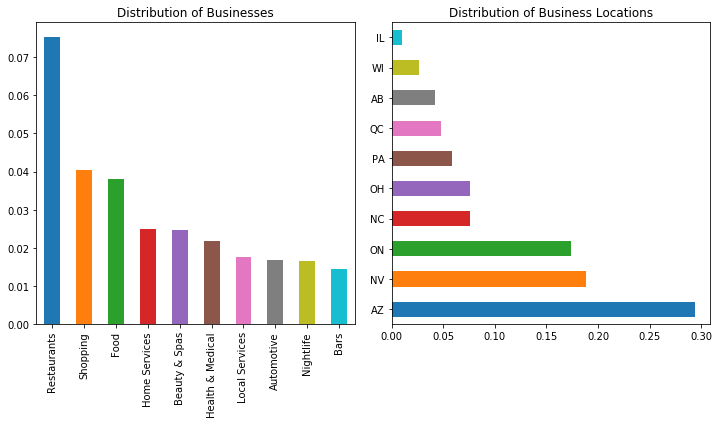

In [3]:
f, ax = plt.subplots(1,2, figsize = [15,6])

ax0 = plt.subplot(131)
cat_df.categories.value_counts(normalize = True)[:10].plot(kind = "bar", ax = ax0)
ax0.set_title("Distribution of Businesses")

ax1 = plt.subplot(132)
business_df.state.value_counts(normalize = True)[:10].plot(kind = "barh", ax = ax1)
ax1.set_title("Distribution of Business Locations")


plt.tight_layout()

### Review data loading and preprocessing
1. We'll narrow our reviews to exclusively restaurants since a different sentiment of usefulness could be assosciated with different business types. Additionally, restaurants happens to be the largest subset of the data.
2. Upon first inspection, one may think that we runn into a problem with predicting how many useful votes a review will get as it is intertwined with how long a review has been up. Clearly, one would think that reviews that have been up longer will accumulate more useful votes. However, based off of the way yelp displays reviews in order to the user, the website accounts for time by implementing an algorithm that attempts to fitler out the order of reviews displayed to users such that it is independent of time by giving newer reviews a boost to display them before older reviews in attempt to counter attack the way that useful votes and time interact with eachother. We'll see later on in the EDA that number of useful votes is more or less independent of time, given that we give reviews atleast a month to accumulate votes. Thus, We'll look at reviews that have had atleast 1 month to accumulate votes, as well as no reviews older than 2014 to ensure we're observing the most recent trends.

We'll see justification for this preprocessing by loading in and examining our first batch of data.

In [4]:
reviews=[]
review_reader = pd.read_json('yelp_dataset/review.json', lines=True, chunksize=100000)
most_recent = pd.Timestamp('2018-11-11 20:55:31')
begin = True
for chunk in review_reader:
    chunk = chunk[chunk.useful >= 0]
    chunk = chunk.merge(restaurant_df[["categories", "business_id"]], how = "inner", on = "business_id")
    chunk.dropna(inplace = True)
    chunk['date'] = pd.to_datetime(chunk['date'])
    chunk['year'] = pd.DatetimeIndex(chunk['date']).year
    chunk['nb_days'] = chunk.date.apply(lambda d: (most_recent - d) / np.timedelta64(1, 'D'))
    chunk['nb_days'] = chunk['nb_days'].astype(int)
    chunk = chunk[chunk.nb_days >= 30]
    chunk = chunk[chunk.year >= 2014]
    chunk["log_useful"] = np.log(chunk.useful+1)
    reviews.append(chunk)
review_df = pd.concat(reviews)
print(review_df.shape)
review_df.head()

(3122279, 13)


,business_id,cool,date,funny,review_id,stars,text,useful,user_id,categories,year,nb_days,log_useful
0,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg,"Bars, Pubs, Nightlife, Tapas Bars, Restaurants",2018,305,0.000000
1,ikCg8xy5JIg_NGPx-MSIDA,0,2015-09-09 22:10:49,0,kSq_5yiDetNh-RRkvpB5Jw,1,"Really one of dirtiest places to eat,not sure ...",0,eKyshoiTpZVF1_U4B9CHEg,"Bars, Pubs, Nightlife, Tapas Bars, Restaurants",2015,1158,0.000000
2,ikCg8xy5JIg_NGPx-MSIDA,0,2014-05-28 00:22:08,0,Lxm5nANkCytCtMrnzYscXg,1,"Terrible place to eat and or drink, waitresses...",1,eKyshoiTpZVF1_U4B9CHEg,"Bars, Pubs, Nightlife, Tapas Bars, Restaurants",2014,1628,0.693147
4,eU_713ec6fTGNO4BegRaww,0,2015-06-08 18:51:54,0,Ci7eLn5l1X1UTIe0COaCrA,5,One of the best Italian restaurants in a city ...,1,y0X59ZwPp89jVkceROxTtA,"Restaurants, Italian, Pizza",2015,1252,0.693147
7,eU_713ec6fTGNO4BegRaww,0,2016-04-23 14:18:21,0,rnWDfIlw_fGqySRWaM84gg,5,A favorite amongst my girlfriends and family. ...,0,Jk0AcqPCVMfc_DTWO3SzwA,"Restaurants, Italian, Pizza",2016,932,0.000000


Text(0.5,1,'Distribution of Reviews by Year')

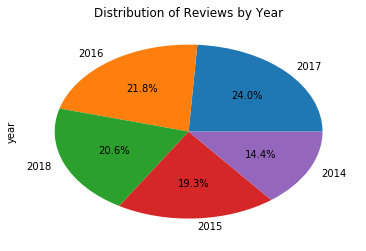

In [5]:
f, ax =plt.subplots()
review_df.year.value_counts(normalize = True)[:10].plot(kind = "pie", autopct="%1.1f%%")
ax.set_title("Distribution of Reviews by Year")

In [6]:
print(review_df.shape)
review_df.drop(columns = ["business_id", "cool", "date", "funny", "review_id", "user_id", "categories", "year"], 
               inplace = True)
review_df.isna().sum()

(3122279, 13)


stars         0
text          0
useful        0
nb_days       0
log_useful    0
dtype: int64

In [7]:
review_df.to_csv('review_df.csv', index=False)